
--- Training Voting Classifier ---

--- Cost Matrix Configuration ---
Normal Class: Other_Faults
Cost of Miss (Fault->Normal): $1,000
Cost of Alarm (Normal->Fault): $50

--- Financial Impact (Test Set: 389 plates) ---
No Intervention (Pass All)         : $254,000.00
Standard Model (Voting Classifier) : $46,450.00
Cost-Optimized Strategy            : $29,350.00

Total Savings vs No Intervention: $224,650.00

--- Deep Dive Metrics ---
Standard Model Accuracy: 80.98%
Optimized Model Accuracy: 61.44%
Standard Model Review Rate: 64.78%
Optimized Model Review Rate: 97.69%
Optimized 'Other_Faults' Predictions: 9
Saved Cost Chart to: outputs/cost_comparison.png


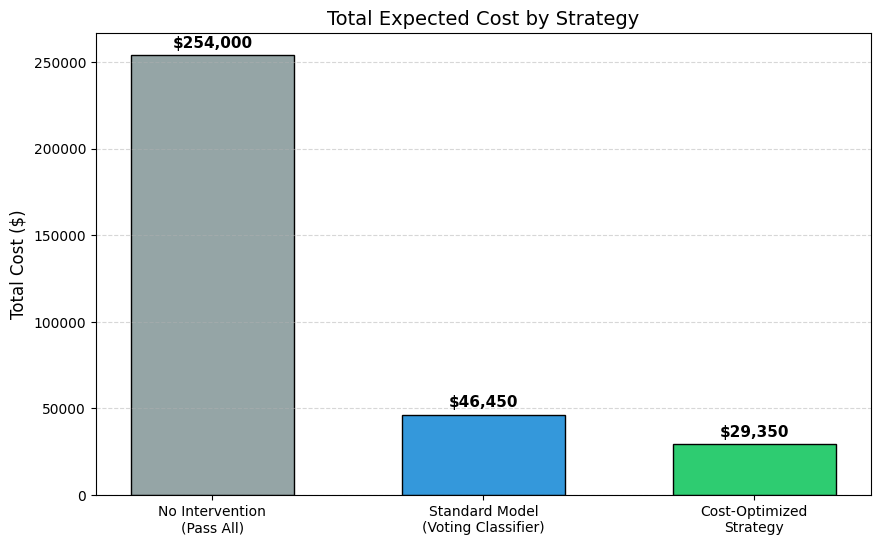

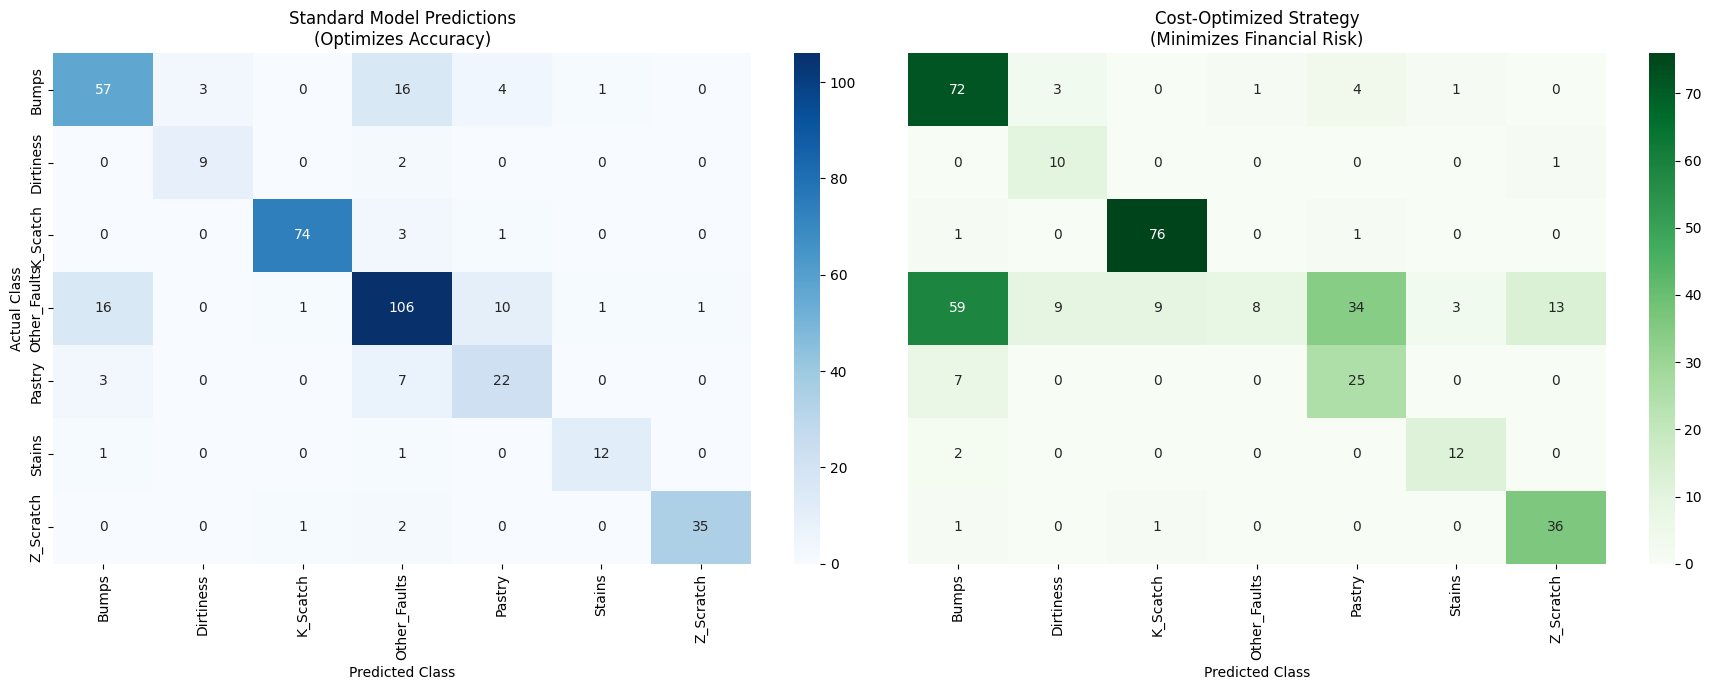

Saved Dual CM to: outputs/dual_confusion_matrix.png


In [1]:
import os
import sys
import zipfile
import urllib.request
from io import BytesIO
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

# ---------------------------------------------------------
# 1. Configuration & Setup
# ---------------------------------------------------------
SEED = 42
DATA_URL = "https://archive.ics.uci.edu/static/public/198/steel+plates+faults.zip"
OUTPUT_DIR = Path("outputs")
CLASS_NAMES = [
    "Pastry", "Z_Scratch", "K_Scatch", "Stains",
    "Dirtiness", "Bumps", "Other_Faults"
]

def setup_env():
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def fetch_data() -> pd.DataFrame:
    print(f"Downloading data from {DATA_URL}...")
    try:
        with urllib.request.urlopen(DATA_URL) as resp:
            with zipfile.ZipFile(BytesIO(resp.read())) as zf:
                target = next(n for n in zf.namelist() if "Faults.NNA" in n or "faults" in n.lower())
                with zf.open(target) as f:
                    df = pd.read_csv(f, sep=r'\s+', header=None)
                    return df
    except Exception as e:
        sys.exit(f"Error downloading data: {e}")

def preprocess_data(df: pd.DataFrame) -> tuple:
    # Rename columns
    feat_cols = [f"V{i}" for i in range(27)]
    df.columns = feat_cols + CLASS_NAMES

    # Filter invalid rows (ensure only one class is 1)
    mask = df[CLASS_NAMES].sum(axis=1) == 1
    df_clean = df[mask].copy()

    X = df_clean[feat_cols]
    # Convert One-Hot to Single Label
    y_raw = df_clean[CLASS_NAMES].idxmax(axis=1)

    le = LabelEncoder()
    y = le.fit_transform(y_raw)

    # Remove Collinear Features
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    X = X.drop(columns=to_drop)

    return X, y, le, X.columns.tolist()

def train_model(X, y):
    print("\n--- Training Voting Classifier ---")
    lgbm = LGBMClassifier(n_estimators=200, learning_rate=0.05, class_weight='balanced', random_state=SEED, verbose=-1)
    rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=-1, random_state=SEED)
    lr = LogisticRegression(class_weight='balanced', max_iter=1000, solver='lbfgs')

    ensemble = VotingClassifier(
        estimators=[('lgbm', lgbm), ('rf', rf), ('lr', lr)],
        voting='soft',
        weights=[3, 2, 1],
        n_jobs=-1
    )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

    ensemble.fit(X_train, y_train)
    return ensemble, X_test, y_test

# ---------------------------------------------------------
# 2. Cost-Benefit Analysis Logic
# ---------------------------------------------------------

def create_cost_matrix(class_names):
    """
    Creates a Cost Matrix based on LabelEncoder classes.
    """
    n_classes = len(class_names)
    cost_matrix = pd.DataFrame(
        np.zeros((n_classes, n_classes)),
        index=class_names,
        columns=class_names
    )

    # Find the index of "Normal" (Other_Faults)
    try:
        other_idx = list(class_names).index('Other_Faults')
    except ValueError:
        print("Warning: 'Other_Faults' not found in classes. Defaulting to last class.")
        other_idx = n_classes - 1

    # Define Costs
    HIGH_COST_MISS = 1000   # Real Fault -> Predicted Other (Severe Miss)
    LOW_COST_ALARM = 50     # Other -> Predicted Fault (False Alarm)
    WRONG_FAULT    = 1000   # Stains -> Predicted Bumps (Classification Error)

    for actual in range(n_classes):
        for pred in range(n_classes):
            if actual == pred:
                cost_matrix.iloc[actual, pred] = 0
            else:
                if actual != other_idx and pred == other_idx:
                    # Dangerous: We missed a defect
                    cost_matrix.iloc[actual, pred] = HIGH_COST_MISS

                elif actual == other_idx and pred != other_idx:
                    # Nuisance: We stopped the line for nothing
                    cost_matrix.iloc[actual, pred] = LOW_COST_ALARM

                else:
                    # Confusion: We found a fault, but named it wrong
                    cost_matrix.iloc[actual, pred] = WRONG_FAULT

    return cost_matrix, other_idx

def calculate_total_cost(y_true, y_pred, cost_matrix, class_names):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    total_cost = np.sum(cm * cost_matrix.values)
    return total_cost, cm

def predict_min_expected_cost(model, X, cost_matrix):
    """
    Predicts class that minimizes expected financial risk.
    """
    # 1. Get Probabilities (n_samples, n_classes)
    probas = model.predict_proba(X)

    # 2. Calculate Expected Risk Matrix
    # (n_samples, n_classes) dot (n_classes, n_classes)
    expected_risks = np.dot(probas, cost_matrix.values)

    # 3. Choose class with lowest risk
    return np.argmin(expected_risks, axis=1)

# ---------------------------------------------------------
# 3. Visualization & Execution
# ---------------------------------------------------------

def run_cost_analysis(model, X_test, y_test, le):
    class_names = le.classes_
    cost_mat, other_idx = create_cost_matrix(class_names)

    print("\n--- Cost Matrix Configuration ---")
    print(f"Normal Class: {class_names[other_idx]}")
    print(f"Cost of Miss (Fault->Normal): $1,000")
    print(f"Cost of Alarm (Normal->Fault): $50")

    results = {}

    # Strategy 1: Baseline (No Intervention / Pass Everything)
    y_pred_baseline = np.full(shape=y_test.shape, fill_value=other_idx)
    cost_base, _ = calculate_total_cost(y_test, y_pred_baseline, cost_mat, class_names)
    results['No Intervention\n(Pass All)'] = cost_base

    # Strategy 2: Standard Model Predictions
    y_pred_std = model.predict(X_test)
    cost_std, cm_std = calculate_total_cost(y_test, y_pred_std, cost_mat, class_names)
    results['Standard Model\n(Voting Classifier)'] = cost_std

    # Strategy 3: Cost-Optimized Predictions
    y_pred_opt = predict_min_expected_cost(model, X_test, cost_mat)
    cost_opt, cm_opt = calculate_total_cost(y_test, y_pred_opt, cost_mat, class_names)
    results['Cost-Optimized\nStrategy'] = cost_opt

    # --- Print Financial Report ---
    print(f"\n--- Financial Impact (Test Set: {len(y_test)} plates) ---")
    for name, cost in results.items():
        clean_name = name.replace('\n', ' ')
        print(f"{clean_name:<35}: ${cost:,.2f}")

    savings = results['No Intervention\n(Pass All)'] - results['Cost-Optimized\nStrategy']
    print(f"\nTotal Savings vs No Intervention: ${savings:,.2f}")

    # --- Deep Dive Metrics ---
    print("\n--- Deep Dive Metrics ---")

    # Accuracy Comparison
    acc_std = np.mean(y_pred_std == y_test)
    acc_opt = np.mean(y_pred_opt == y_test)
    print(f"Standard Model Accuracy: {acc_std:.2%}")
    print(f"Optimized Model Accuracy: {acc_opt:.2%}")

    # Review Rate (Rate of non-normal predictions)
    review_rate_std = np.mean(y_pred_std != other_idx)
    review_rate_opt = np.mean(y_pred_opt != other_idx)
    print(f"Standard Model Review Rate: {review_rate_std:.2%}")
    print(f"Optimized Model Review Rate: {review_rate_opt:.2%}")

    # Other_Faults Count
    other_pred_count = np.sum(y_pred_opt == other_idx)
    print(f"Optimized 'Other_Faults' Predictions: {other_pred_count}")

    # --- Plotting ---

    # 1. Bar Chart: Strategy Comparison
    plt.figure(figsize=(10, 6))
    strategies = list(results.keys())
    costs = list(results.values())
    colors = ['#95a5a6', '#3498db', '#2ecc71'] # Grey, Blue, Green

    bars = plt.bar(strategies, costs, color=colors, edgecolor='black', width=0.6)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + (max(costs)*0.01),
                 f'${yval:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

    plt.title('Total Expected Cost by Strategy', fontsize=14)
    plt.ylabel('Total Cost ($)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Save Bar Chart
    bar_path = OUTPUT_DIR / "cost_comparison.png"
    plt.savefig(bar_path, dpi=300)
    print(f"Saved Cost Chart to: {bar_path}")

    # 2. Dual Confusion Matrix
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # Plot Standard
    sns.heatmap(cm_std, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=class_names, yticklabels=class_names)
    axes[0].set_title('Standard Model Predictions\n(Optimizes Accuracy)')
    axes[0].set_ylabel('Actual Class')
    axes[0].set_xlabel('Predicted Class')

    # Plot Optimized
    sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=class_names, yticklabels=class_names)
    axes[1].set_title('Cost-Optimized Strategy\n(Minimizes Financial Risk)')
    axes[1].set_xlabel('Predicted Class')
    axes[1].set_ylabel('')
    axes[1].set_yticks([])

    plt.tight_layout()
    cm_path = OUTPUT_DIR / "dual_confusion_matrix.png"
    plt.savefig(cm_path, dpi=300)
    plt.show()
    print(f"Saved Dual CM to: {cm_path}")

# ---------------------------------------------------------
# 4. Main Pipeline
# ---------------------------------------------------------
if __name__ == "__main__":
    setup_env()

    # Data Pipeline
    df_raw = fetch_data()
    X, y, le, feats = preprocess_data(df_raw)

    # Scale Data
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feats)

    # Train Model (Voting Classifier)
    model, X_test, y_test = train_model(X_scaled, y)

    # Run Analysis
    run_cost_analysis(model, X_test, y_test, le)